In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
import pywt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [133]:
# 数据预处理
# 训练集
material_1 = pd.read_excel('F:/00程序/Githubclone_Projects/ICNN/datasets/CoreLosses/附件一（训练集）.xlsx', sheet_name='材料1')
material_2 = pd.read_excel('F:/00程序/Githubclone_Projects/ICNN/datasets/CoreLosses/附件一（训练集）.xlsx', sheet_name='材料2')
material_3 = pd.read_excel('F:/00程序/Githubclone_Projects/ICNN/datasets/CoreLosses/附件一（训练集）.xlsx', sheet_name='材料3')
material_4 = pd.read_excel('F:/00程序/Githubclone_Projects/ICNN/datasets/CoreLosses/附件一（训练集）.xlsx', sheet_name='材料4')

In [134]:
combined_material = pd.concat([material_1, material_2, material_3, material_4], axis=0, ignore_index=True)
print(type(combined_material))
combined_material

<class 'pandas.core.frame.DataFrame'>


,温度，oC,频率，Hz,磁芯损耗，w/m3,励磁波形,0（磁通密度B，T）,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,25,50030,1997.955250,正弦波,0.000213,0.000389,0.000566,0.000743,0.000919,0.001096,...,-0.001551,-0.001374,-0.001198,-0.001022,-0.000846,-0.000669,-0.000492,-0.000316,-0.000140,0.000036
1,25,50020,2427.749830,正弦波,-0.000551,-0.000358,-0.000165,0.000028,0.000221,0.000413,...,-0.002476,-0.002284,-0.002091,-0.001899,-0.001707,-0.001515,-0.001322,-0.001129,-0.000937,-0.000744
2,25,50020,3332.725760,正弦波,-0.003780,-0.003564,-0.003349,-0.003134,-0.002919,-0.002704,...,-0.005927,-0.005713,-0.005499,-0.005285,-0.005070,-0.004855,-0.004640,-0.004425,-0.004210,-0.003995
3,25,50020,4502.908007,正弦波,-0.000511,-0.000267,-0.000023,0.000222,0.000466,0.000711,...,-0.002950,-0.002707,-0.002463,-0.002220,-0.001976,-0.001732,-0.001488,-0.001244,-0.001000,-0.000756
4,25,50030,6063.023248,正弦波,0.000458,0.000732,0.001007,0.001281,0.001555,0.001830,...,-0.002290,-0.002016,-0.001741,-0.001466,-0.001192,-0.000917,-0.000642,-0.000367,-0.000092,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12395,90,199190,20604.900210,梯形波,-0.017758,-0.017339,-0.016932,-0.016534,-0.016140,-0.015745,...,-0.020170,-0.020013,-0.019854,-0.019692,-0.019528,-0.019356,-0.019157,-0.018903,-0.018573,-0.018180
12396,90,199190,26504.284280,梯形波,-0.019690,-0.019227,-0.018776,-0.018334,-0.017895,-0.017456,...,-0.022407,-0.022236,-0.022062,-0.021886,-0.021706,-0.021513,-0.021285,-0.020987,-0.020605,-0.020159
12397,90,199190,46232.491530,梯形波,-0.024998,-0.024411,-0.023838,-0.023278,-0.022722,-0.022165,...,-0.028409,-0.028189,-0.027966,-0.027739,-0.027509,-0.027266,-0.026981,-0.026614,-0.026142,-0.025587
12398,90,199190,61458.085900,梯形波,-0.027988,-0.027329,-0.026687,-0.026060,-0.025438,-0.024816,...,-0.031817,-0.031568,-0.031314,-0.031056,-0.030793,-0.030516,-0.030196,-0.029787,-0.029264,-0.028647


In [135]:
# 标签
combined_material_label = np.zeros(combined_material.shape[0])

for i in range(combined_material.shape[0]):
    if combined_material.iloc[i,3] == '正弦波':
        combined_material_label[i] = 1
    elif combined_material.iloc[i,3] == '三角波':
        combined_material_label[i] = 2
    elif combined_material.iloc[i,3] == '梯形波':
        combined_material_label[i] = 3
combined_material_label = combined_material_label.astype(int)
combined_material_label

array([1, 1, 1, ..., 3, 3, 3])

In [136]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

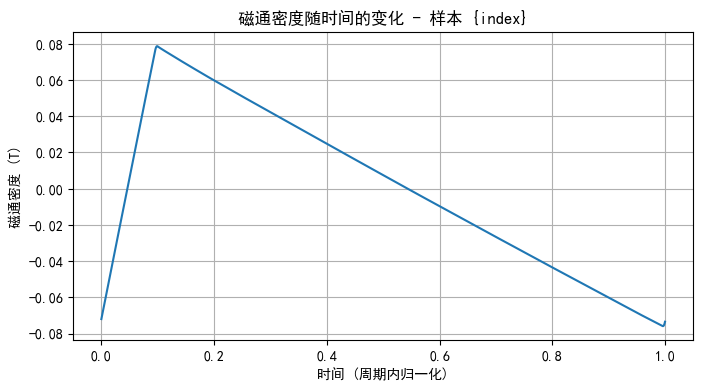

In [137]:
# 可视化
def plot_wave(index):
    sample = combined_material.iloc[index, 4:].values
    time = np.linspace(0, 1, len(sample))
    plt.figure(figsize=(8, 4))
    plt.plot(time, sample)
    plt.title("磁通密度随时间的变化 - 样本 {index}")
    plt.xlabel("时间 (周期内归一化)")
    plt.ylabel("磁通密度 (T)")
    plt.grid(True)
    plt.show()
plot_wave(1067)

In [138]:
# 抓取特征
    # 峰值：波形的最大值和最小值。
    # 均值：波形的平均值。
    # 标准差：波形的波动程度。
    # 峰度：波形的尖锐程度。
    # 偏度：波形的对称性。
    # 频率成分：通过傅里叶变换得到的主要频率成分。
    # 小波变换：通过小波变换得到的主要小波成分。
def get_features(data):
    wave_features = []
    for _,row in data.iterrows():
        wave_signal = row.iloc[4:].values
        
         # 时间域特征
        features_in_time = [
            np.max(wave_signal),
            np.min(wave_signal),
            np.mean(wave_signal),
            np.std(wave_signal),
            np.median(wave_signal),
            np.ptp(wave_signal),
            np.var(wave_signal)
        ]
        
   
        # 频域特征
        fft_values = np.abs(fft(wave_signal))
        features_in_freq = [
            np.max(fft_values), 
            np.mean(fft_values), 
            np.sum(fft_values), 
            np.std(fft_values), 
            np.median(fft_values)
        ]
        
        # 小波特征
        co_effs = pywt.wavedec(wave_signal, 'db4', level=4)
        features_in_detail = [np.mean(c) for c in co_effs] + [np.std(c) for c in co_effs]
    
        wave_features.append(features_in_time + features_in_freq + features_in_detail) 
    return np.array(wave_features)

In [144]:
combined_material_features = get_features(combined_material)
X = combined_material_features
y = combined_material_label
X

array([[ 2.88486250e-02, -2.88401630e-02, -4.00390764e-11, ...,
         9.66297591e-05,  2.21706175e-05,  8.86861504e-07],
       [ 3.14191760e-02, -3.14273000e-02, -2.53906240e-11, ...,
         1.05522371e-04,  2.42461542e-05,  9.67413828e-07],
       [ 3.55347280e-02, -3.55125410e-02, -9.76569853e-13, ...,
         1.17715582e-04,  2.70143607e-05,  1.06946314e-06],
       ...,
       [ 4.88770520e-02, -4.79338460e-02, -7.81250033e-11, ...,
         3.07991191e-04,  8.10286519e-05,  3.80140707e-06],
       [ 5.48890530e-02, -5.38803110e-02,  6.34765378e-11, ...,
         3.44703990e-04,  9.01438207e-05,  4.17984762e-06],
       [ 6.91354850e-02, -6.77708490e-02, -4.68749949e-11, ...,
         4.35272762e-04,  1.13329026e-04,  5.17674903e-06]])

In [140]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       797
           2       1.00      1.00      1.00       977
           3       0.99      1.00      0.99       706

    accuracy                           1.00      2480
   macro avg       1.00      1.00      1.00      2480
weighted avg       1.00      1.00      1.00      2480


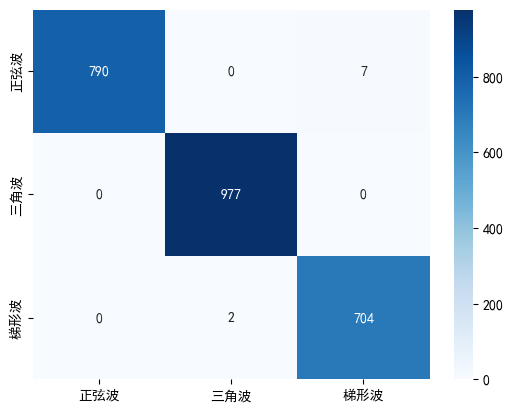

In [146]:
# 法1：梯度提升决策树分类器gbdt
gbdt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gbdt.fit(X_train, y_train)
y_pred = gbdt.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['正弦波', '三角波', '梯形波'], yticklabels=['正弦波', '三角波', '梯形波'])
plt.show()

              precision    recall  f1-score   support

           1       0.89      1.00      0.94       797
           2       0.63      0.73      0.68       977
           3       0.53      0.35      0.42       706

    accuracy                           0.71      2480
   macro avg       0.69      0.69      0.68      2480
weighted avg       0.69      0.71      0.69      2480


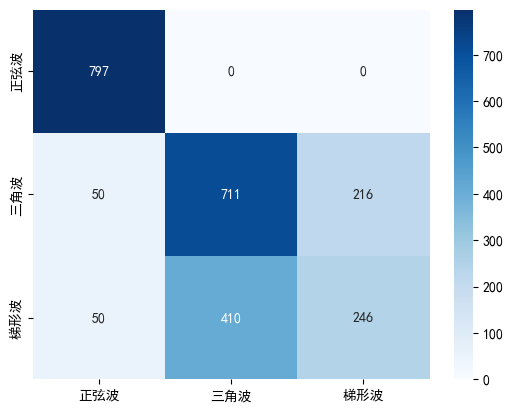

In [154]:
# 法2：SVM方法
svm = SVC(probability=True, kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['正弦波', '三角波', '梯形波'], yticklabels=['正弦波', '三角波', '梯形波'])
plt.show()

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       797
           2       1.00      1.00      1.00       977
           3       1.00      1.00      1.00       706

    accuracy                           1.00      2480
   macro avg       1.00      1.00      1.00      2480
weighted avg       1.00      1.00      1.00      2480


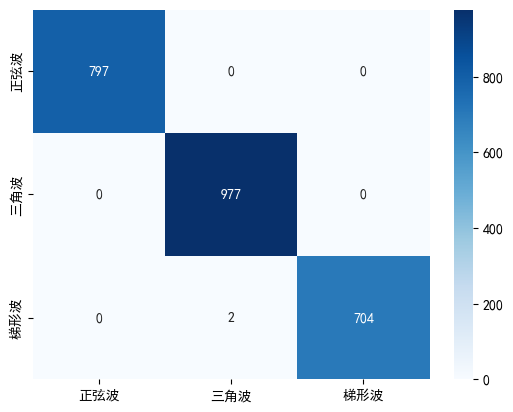

In [155]:
# 法3：随机森林分类器
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['正弦波', '三角波', '梯形波'], yticklabels=['正弦波', '三角波', '梯形波'])
plt.show()

In [156]:
# 测试集
material_test = pd.read_excel('F:/00程序/Githubclone_Projects/ICNN/datasets/CoreLosses/附件二（测试集）.xlsx')
test_material_features = get_features(material_test)
X_test = pd.DataFrame(test_material_features)

In [148]:
# 法1
y_test1 = gbdt.predict(X_test)
y_test1

array([2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3,
       3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 2, 2, 1, 1, 1, 1, 1])

In [157]:
# 法2
y_test2 = svm.predict(X_test)
y_test2

array([2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 1, 1, 1, 1, 1, 3, 1, 2, 1, 2, 2, 2, 2, 3, 3, 2, 2, 1, 3,
       3, 1, 1, 1, 1, 1, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1])

In [158]:
# 法3
y_test3 = rf.predict(X_test)
y_test3

array([2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3,
       3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 2, 2, 1, 1, 1, 1, 1])

In [ ]:
fill_data = pd.read_excel('F:/00程序/Githubclone_Projects/ICNN/datasets/CoreLosses/附件四（Excel表）.xlsx')
fill_data

In [ ]:
fill_data['附件二（80个样品）励磁波形分类结果']= pd.Series(y_test.map({1: '正弦波', 2: '三角波', 3: '梯形波'}))